In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Projects/US-Visa-Approval-Prediction/notebook/EasyVisa.csv')
df.shape

(25480, 12)

Data Cleaning

In [3]:
# Handle missing values
df.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

No missing values in any of the columns

Handling duplicates

In [4]:
df.duplicated().sum()

np.int64(0)

No duplicate values in any of the columns

Removing case_id from the dataset

In [5]:
df.drop('case_id', axis=1, inplace=True)

### Feature Engineering

Feature Extraction

In [6]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [7]:
# Calculate age of the company from the year established
import datetime
current_year = datetime.datetime.now().year
df['company_age'] = current_year - df['yr_of_estab']

In [8]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


In [9]:
df.drop('yr_of_estab', axis=1, inplace=True)

### Split X and Y

In [10]:
X = df.drop('case_status', axis=1)
y = df['case_status'].map({'Denied': 0, 'Certified':1})
X.shape, y.shape

((25480, 10), (25480,))

In [11]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int64

Feature transformation

In [12]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])

In [13]:
X_copy = pd.DataFrame(X_copy, columns=transform_features)
X_copy.head()

,company_age,no_of_employees
0,-0.955551,1.517300
1,-0.467001,0.030912
2,-1.078363,2.885076
3,1.630914,-1.343550
4,-0.738126,-0.432287


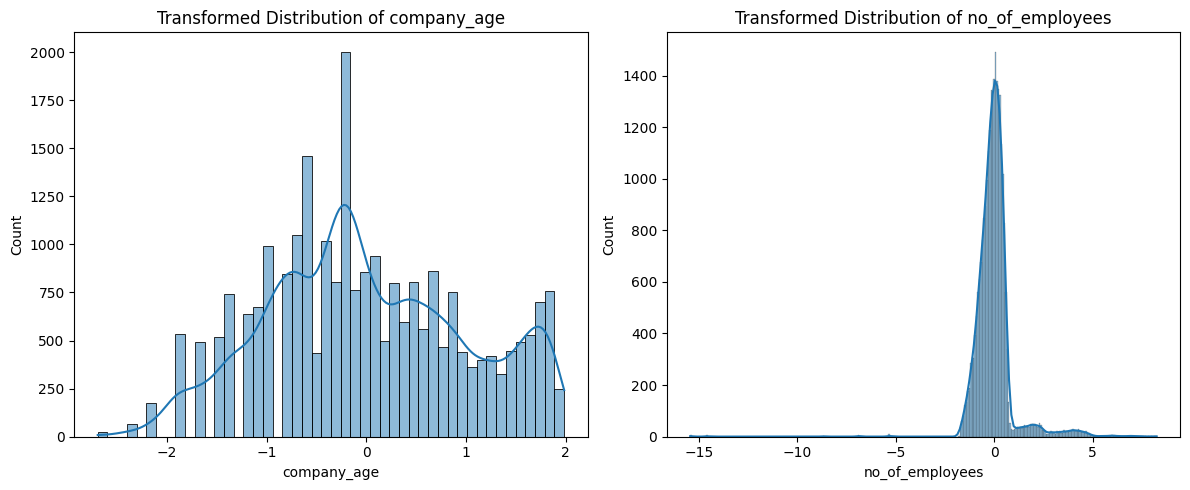

In [14]:
plt.figure(figsize=(12,5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(X_copy[col], kde=True)
    plt.title(f'Transformed Distribution of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    

Checking Skewness

In [15]:
X_copy.skew(axis=0, skipna=True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

In [16]:

num_features = list(X.select_dtypes(exclude="object").columns)

Preprocessing using Column Transformer

In [17]:
# Create Column Transformer with 3 types of transformers
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [18]:
X = preprocessor.fit_transform(X)

In [19]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]], shape=(25480, 24))

Handling data imbalance

In [20]:
from imblearn.combine import SMOTETomek, SMOTEENN
smt = SMOTETomek(random_state=42, sampling_strategy='minority')
X_res, y_res = smt.fit_resample(X,y)

Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((24990, 24), (6248, 24))

Import list of classifiers to train the model

In [23]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [24]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "XGBoost": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False)
}

In [26]:
# evaluation function
def evaluate_clf(true, predicted):
    accuracy = accuracy_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return accuracy, precision, recall, f1, roc_auc

In [29]:
def evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []
    auc = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)

        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # training data performance
        model_train_accuracy, model_train_precision, model_train_recall, model_train_f1, model_train_roc_auc = evaluate_clf(y_train, y_train_pred)

        # testing data performance
        model_test_accuracy, model_test_precision, model_test_recall, model_test_f1, model_test_roc_auc = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        accuracy_list.append(model_test_accuracy)
        auc.append(model_test_roc_auc)

        print("Model performance for Training Data:")
        print("Accuracy: {:.4f}".format(model_train_accuracy))
        print("Precision{:.4f}".format(model_train_precision))
        print("Recall: {:.4f}".format(model_train_recall))
        print("F1 Score: {:.4f}".format(model_train_f1))
        print("ROC AUC Score: {:.4f}".format(model_train_roc_auc))
        print("\n")


        print("Model performance for Testing Data:")
        print("Accuracy: {:.4f}".format(model_test_accuracy))
        print("Precision{:.4f}".format(model_test_precision))
        print("Recall: {:.4f}".format(model_test_recall))
        print("F1 Score: {:.4f}".format(model_test_f1))
        print("ROC AUC Score: {:.4f}".format(model_test_roc_auc))
        print("\n")

    model_performace = pd.DataFrame(
        list(zip(models_list, accuracy_list)), columns=['Model', 'Accuracy score']
    ).sort_values(by='Accuracy score', ascending=False)
    return model_performace




In [30]:
model_report = evaluate_models(X_res, y_res, models=models)

Random Forest
Model performance for Training Data:
Accuracy: 1.0000
Precision1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000


Model performance for Testing Data:
Accuracy: 0.8225
Precision0.8379
Recall: 0.8076
F1 Score: 0.8225
ROC AUC Score: 0.8228


Decision Tree
Model performance for Training Data:
Accuracy: 1.0000
Precision1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000


Model performance for Testing Data:
Accuracy: 0.7487
Precision0.7603
Recall: 0.7397
F1 Score: 0.7498
ROC AUC Score: 0.7489


Logistic Regression
Model performance for Training Data:
Accuracy: 0.6397
Precision0.6305
Recall: 0.6669
F1 Score: 0.6482
ROC AUC Score: 0.6398


Model performance for Testing Data:
Accuracy: 0.6436
Precision0.6446
Recall: 0.6683
F1 Score: 0.6563
ROC AUC Score: 0.6431


AdaBoost
Model performance for Training Data:
Accuracy: 0.7257
Precision0.7278
Recall: 0.7171
F1 Score: 0.7224
ROC AUC Score: 0.7257


Model performance for Testing Data:
Accuracy: 0.7294
Precision0.

In [31]:
model_report

,Model,Accuracy score
0,Random Forest,0.822503
8,CatBoosting Classifier,0.816901
7,XGBoost,0.806818
5,K-Nearest Neighbors,0.769046
4,Gradient Boosting,0.765685
1,Decision Tree,0.748720
6,Support Vector Classifier,0.731594
3,AdaBoost,0.729353
2,Logistic Regression,0.643566


Top 3 models can be considered for hyperparameter tuning

In [32]:
rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 150]
}

cat_params = {
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.02, 0.05],
    "iterations": [500, 1000, 1500]
}

xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}


In [33]:
randomcv_models = [
    ('RF', RandomForestClassifier(), rf_params),
    ('XGB', XGBClassifier(), xgboost_params),
    ('CB', CatBoostClassifier(), cat_params)
]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}

for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=params,
                                n_iter=100,
                                cv=3,
                                verbose=2)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f'Best params for {model_name}')
    print(model_param[model_name])

In [35]:
model_param

{'RF': {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': None},
 'XGB': {'min_child_weight': 1, 'max_depth': 9}}

Retraining the model with best parameters

In [36]:
from sklearn.metrics import roc_auc_score, roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "XGBoost Classifier": XGBClassifier(**model_param['XGB'], n_jobs=-1),
}
tuned_report = evaluate_models(X_res, y_res, models=best_models)

Random Forest Classifier
Model performance for Training Data:
Accuracy: 1.0000
Precision1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC Score: 1.0000


Model performance for Testing Data:
Accuracy: 0.8195
Precision0.8356
Recall: 0.8035
F1 Score: 0.8192
ROC AUC Score: 0.8198


XGBoost Classifier
Model performance for Training Data:
Accuracy: 0.9591
Precision0.9584
Recall: 0.9595
F1 Score: 0.9589
ROC AUC Score: 0.9591


Model performance for Testing Data:
Accuracy: 0.8049
Precision0.8085
Recall: 0.8082
F1 Score: 0.8084
ROC AUC Score: 0.8048




In [37]:
tuned_report

,Model,Accuracy score
0,Random Forest Classifier,0.819462
1,XGBoost Classifier,0.804898


In [38]:
best_model = RandomForestClassifier(**model_param['RF'])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Final model Random  forest")
print("Accuracy:", score)
print(cr)

Final model Random  forest
Accuracy: 0.8188220230473752
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3067
           1       0.84      0.80      0.82      3181

    accuracy                           0.82      6248
   macro avg       0.82      0.82      0.82      6248
weighted avg       0.82      0.82      0.82      6248



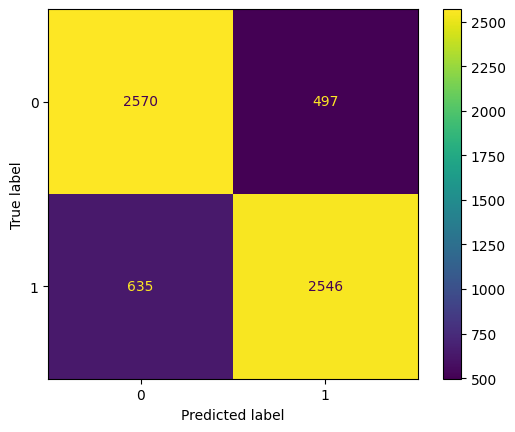

In [39]:

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)